In [1]:
import tensorflow as tf
import torch

# Check TensorFlow
print("TensorFlow is using:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Check PyTorch
print("PyTorch is using:", "GPU" if torch.cuda.is_available() else "CPU")

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TensorFlow to use CPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = torch.device("cpu")
print("Using CPU for processing.")

import os
print(os.getcwd())  # This shows your current directory

import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from transformers import pipeline
import torch
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ✅ Check if PyTorch is using GPU or CPU
try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
except ImportError:
    raise ImportError("Please install PyTorch by running 'pip install torch'")

# ✅ Ensure data files exist
if not os.path.exists("stock_data.csv"):
    raise FileNotFoundError("Error: stock_data.csv not found! Place it in the correct folder.")
if not os.path.exists("news_data.csv"):
    raise FileNotFoundError("Error: news_data.csv not found! Place it in the correct folder.")

# ✅ Load data
stock_data = pd.read_csv('stock_data.csv')
news_data = pd.read_csv('news_data.csv')

# ✅ Ensure required columns exist
required_stock_columns = ['date', 'open', 'close', 'volume']
required_news_columns = ['date', 'news_summary']

for col in required_stock_columns:
    if col not in stock_data.columns:
        raise KeyError(f"Error: '{col}' column is missing from stock_data.csv.")
for col in required_news_columns:
    if col not in news_data.columns:
        raise KeyError(f"Error: '{col}' column is missing from news_data.csv.")

# ✅ Initialize sentiment pipeline
sentiment_pipeline = pipeline(
    'sentiment-analysis',
    model='distilbert-base-uncased-finetuned-sst-2-english',
    device=-1  # Use CPU for stability
)

# ✅ Process news sentiment analysis
def get_sentiment(news_summary):
    try:
        return sentiment_pipeline(news_summary)[0]['label']
    except Exception as e:
        print(f"Error processing sentiment for summary: {news_summary}. Error: {e}")
        return 'POSITIVE'  # Default to 'POSITIVE' instead of 'NEUTRAL' (to avoid mapping errors)

news_data['sentiment'] = news_data['news_summary'].apply(get_sentiment)
news_data['sentiment'] = news_data['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': -1})  # Removed 'NEUTRAL'
news_data['date'] = pd.to_datetime(news_data['date'], infer_datetime_format=True)
news_data = news_data.groupby('date').agg({'sentiment': 'mean'}).reset_index()

# ✅ Fill missing dates in news data
news_data = news_data.set_index('date').resample('D').ffill().reset_index()

# ✅ Process stock_data
stock_data['date'] = pd.to_datetime(stock_data['date'], infer_datetime_format=True)
stock_data = stock_data.set_index('date').resample('D').ffill().reset_index()

# ✅ Merge stock and news data
merged_data = pd.merge(stock_data, news_data, on='date', how='left').fillna(0)
print("\n✅ Merged data before filtering:")
print(merged_data.head())

# ✅ Prepare features and targets
X = merged_data[['sentiment', 'volume']]  # Features
y_close = merged_data['close']
y_open = merged_data['open']

# ✅ Handle missing values
imputer_X = SimpleImputer(strategy='mean')
imputer_y_close = SimpleImputer(strategy='mean')
imputer_y_open = SimpleImputer(strategy='mean')

X = imputer_X.fit_transform(X)
y_close = imputer_y_close.fit_transform(y_close.values.reshape(-1, 1)).ravel()
y_open = imputer_y_open.fit_transform(y_open.values.reshape(-1, 1)).ravel()

# ✅ Reshape X for LSTM (samples, time_steps=1, features=2)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

# ✅ Split data into training & testing sets
X_train, X_test, y_train_close, y_test_close = train_test_split(X, y_close, test_size=0.2, shuffle=False)
_, _, y_train_open, y_test_open = train_test_split(X, y_open, test_size=0.2, shuffle=False)

# ✅ Build LSTM model function
def build_lstm_model():
    model = Sequential([
        LSTM(64, input_shape=(1, 2), return_sequences=False),
        Dense(1)
    ])
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam')
    return model

# ✅ Train LSTM models
model_close = build_lstm_model()
model_open = build_lstm_model()

print("\n✅ Training LSTM models...")
model_close.fit(X_train, y_train_close, epochs=10, batch_size=16, verbose=1)
model_open.fit(X_train, y_train_open, epochs=10, batch_size=16, verbose=1)

# ✅ Evaluate models
y_pred_close = model_close.predict(X_test)
y_pred_open = model_open.predict(X_test)

mse_close = mean_squared_error(y_test_close, y_pred_close)
mse_open = mean_squared_error(y_test_open, y_pred_open)

print(f"\n✅ LSTM MSE (Close): {mse_close}")
print(f"✅ LSTM MSE (Open): {mse_open}")

# ✅ Save trained models
model_close.save('stock_price_model_close.h5')
model_open.save('stock_price_model_open.h5')

# ✅ Run predictions
def predict_stock_price(news_data_file, output_file):
    new_data = pd.read_csv(news_data_file)

    # Check required columns
    if 'news_summary' not in new_data.columns or 'date' not in new_data.columns:
        raise KeyError("Error: Required columns are missing in the news data file.")

    # Process sentiment
    new_data['sentiment'] = new_data['news_summary'].apply(get_sentiment)
    new_data['sentiment'] = new_data['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': -1})
    new_data['date'] = pd.to_datetime(new_data['date'], infer_datetime_format=True)

    # Add missing volume column
    if 'volume' not in new_data.columns:
        new_data['volume'] = 0

    # Prepare input
    X_new = new_data[['sentiment', 'volume']]
    X_new = imputer_X.transform(X_new)
    X_new = np.reshape(X_new, (X_new.shape[0], 1, X_new.shape[1]))

    # Load trained models
    lstm_close = tf.keras.models.load_model('stock_price_model_close.h5')
    lstm_open = tf.keras.models.load_model('stock_price_model_open.h5')

    # Make predictions
    predictions_close = lstm_close.predict(X_new).ravel()
    predictions_open = lstm_open.predict(X_new).ravel()

    new_data['predicted_close'] = predictions_close
    new_data['predicted_open'] = predictions_open
    new_data['predicted_avg'] = (predictions_open + predictions_close) / 2

    # Save results
    new_data.to_csv(output_file, index=False)
    print("\n✅ Predictions saved to:", output_file)
    return new_data

predictions = predict_stock_price('new_news_data.csv', 'predicted_stock_prices.csv')
print("\n✅ Predictions:\n", predictions.head())

import pandas as pd
df = pd.read_csv("predicted_stock_prices.csv")
print(df.head())




TensorFlow is using: CPU
PyTorch is using: CPU
Using CPU for processing.
c:\Users\sharm\GDG Stock market model
Using device: cpu


Device set to use cpu
C:\Users\sharm\AppData\Local\Temp\ipykernel_22112\454053934.py:78: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  news_data['date'] = pd.to_datetime(news_data['date'], infer_datetime_format=True)


ValueError: time data "15/01/2010" doesn't match format "%m/%d/%Y", at position 2. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
print("\n✅ Training LSTM models...")
model_close.fit(X_train, y_train_close, epochs=10, batch_size=16, verbose=1)
model_open.fit(X_train, y_train_open, epochs=10, batch_size=16, verbose=1)


In [ ]:
import os
print("Current Directory:", os.getcwd())
print("Files in directory:", os.listdir())


In [ ]:
import pandas as pd

# ✅ Load Data
news_data = pd.read_csv("news_data.csv")
stock_data = pd.read_csv("stock_data.csv")

# ✅ Print Columns
print("\n✅ News Data Columns:", news_data.columns)
print("\n✅ Stock Data Columns:", stock_data.columns)

# ✅ Show First Few Rows
print("\n✅ News Data Sample:\n", news_data.head())
print("\n✅ Stock Data Sample:\n", stock_data.head())


In [ ]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")

# ✅ Apply Sentiment Analysis
news_data['sentiment'] = news_data['news_summary'].apply(lambda x: sentiment_pipeline(x)[0]['label'])
news_data['sentiment'] = news_data['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': -1})

print("\n✅ Sentiment Analysis Completed!")
print(news_data.head())  # Verify it worked


In [ ]:
print("Stock Data Columns:", stock_data.columns)
print("News Data Columns:", news_data.columns)


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from transformers import pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print("✅ All Libraries Imported Successfully!")



✅ All Libraries Imported Successfully!


In [ ]:
# ✅ Check if 'sentiment' column is missing before merging
if 'sentiment' not in news_data.columns:
    print("\n❌ ERROR: 'sentiment' column is missing in news_data! Fixing it now...")

    # Re-run sentiment analysis
    def get_sentiment(text):
        try:
            return sentiment_pipeline(text)[0]['label']
        except:
            return 'POSITIVE'  # Default to avoid errors

    news_data['sentiment'] = news_data['news_summary'].apply(get_sentiment)
    news_data['sentiment'] = news_data['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': -1})  # No NEUTRAL


NameError: name 'news_data' is not defined

In [ ]:
import pandas as pd

# ✅ Reload News Data
news_data = pd.read_csv("news_data.csv")

# ✅ Ensure Required Columns Exist
if 'date' not in news_data.columns:
    raise KeyError("❌ 'date' column is missing in news_data.csv!")

if 'news_summary' not in news_data.columns:
    raise KeyError("❌ 'news_summary' column is missing in news_data.csv!")

print("\n✅ News Data Loaded Successfully!")
print(news_data.head())  # Show first few rows



✅ News Data Loaded Successfully!
         date                                              title  \
0  01/01/2010  Madanjeet Singh to give USD 0.5 million for Ka...   
1  01/01/2010                           A new night to celebrate   
2  01/01/2010       How Gautam Adani anchors his Rs 30kcr empire   
3  01/01/2010   Uttarakhand to go ahead with power privatisation   
4  01/01/2010  Scientists use synthetic genome to create life...   

                                        news_summary  
0  UNESCO Goodwill Ambassador and Founder of the ...  
1  India's most innovative deals have finally bee...  
2  Adani has seen his ventures prosper at a brisk...  
3  Despite vehement political opposition, the Utt...  
4  Scientists have shown that a bacterial cell ca...  


In [ ]:
from transformers import pipeline

# ✅ Download Model to Avoid Repeated Downloading
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

# ✅ Initialize Sentiment Pipeline with Specific Model
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, device=-1)  # CPU Mode

# ✅ Apply Sentiment Analysis
news_data['sentiment'] = news_data['news_summary'].apply(lambda x: sentiment_pipeline(x)[0]['label'])
news_data['sentiment'] = news_data['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': -1})  # Neutral Removed

print("\n✅ Sentiment Analysis Completed!")
print(news_data.head())  # Verify results


Device set to use cpu


In [ ]:
import pandas as pd  # ✅ Import pandas (Fixes the error)

# ✅ Load `news_data.csv`
news_data = pd.read_csv("news_data.csv")

# ✅ Convert `date` Column to Datetime Format
news_data['date'] = pd.to_datetime(news_data['date'], dayfirst=True, errors='coerce')

print("\n✅ News Data Loaded Successfully!")
print(news_data.head())  # Show first few rows



✅ News Data Loaded Successfully!
        date                                              title  \
0 2010-01-01  Madanjeet Singh to give USD 0.5 million for Ka...   
1 2010-01-01                           A new night to celebrate   
2 2010-01-01       How Gautam Adani anchors his Rs 30kcr empire   
3 2010-01-01   Uttarakhand to go ahead with power privatisation   
4 2010-01-01  Scientists use synthetic genome to create life...   

                                        news_summary  
0  UNESCO Goodwill Ambassador and Founder of the ...  
1  India's most innovative deals have finally bee...  
2  Adani has seen his ventures prosper at a brisk...  
3  Despite vehement political opposition, the Utt...  
4  Scientists have shown that a bacterial cell ca...  


In [ ]:
import pandas as pd  # ✅ Import pandas (Fixes the error)

# ✅ Load `stock_data.csv`
stock_data = pd.read_csv("stock_data.csv")

# ✅ Convert `date` Column to Datetime Format
stock_data['date'] = pd.to_datetime(stock_data['date'], dayfirst=True, errors='coerce')

print("\n✅ Stock Data Loaded Successfully!")
print(stock_data.head())  # Show first few rows



✅ Stock Data Loaded Successfully!
                 date    open   high     low   close   volume
0 2010-01-04 15:30:00   99.25  100.0   98.60   99.00   370563
1 2010-01-05 15:30:00   99.90  112.9   99.50  105.05  8432683
2 2010-01-06 15:30:00  106.50  110.8  106.00  107.45  6297126
3 2010-01-07 15:30:00  107.45  108.2  104.65  104.95  1229154
4 2010-01-08 15:30:00  105.25  107.0  103.15  103.70  1033660


In [ ]:
print("\n✅ News Data Columns:", news_data.columns)
print(news_data.head())  # Display first few rows



✅ News Data Columns: Index(['date', 'title', 'news_summary'], dtype='object')
        date                                              title  \
0 2010-01-01  Madanjeet Singh to give USD 0.5 million for Ka...   
1 2010-01-01                           A new night to celebrate   
2 2010-01-01       How Gautam Adani anchors his Rs 30kcr empire   
3 2010-01-01   Uttarakhand to go ahead with power privatisation   
4 2010-01-01  Scientists use synthetic genome to create life...   

                                        news_summary  
0  UNESCO Goodwill Ambassador and Founder of the ...  
1  India's most innovative deals have finally bee...  
2  Adani has seen his ventures prosper at a brisk...  
3  Despite vehement political opposition, the Utt...  
4  Scientists have shown that a bacterial cell ca...  


In [ ]:
from transformers import pipeline

# ✅ Ensure Sentiment Model is Preloaded (to avoid repeated downloads)
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

print("\n✅ Loading Sentiment Analysis Model...")
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, device=-1)  # Use CPU
print("\n✅ Model Loaded Successfully!")



✅ Loading Sentiment Analysis Model...


Device set to use cpu



✅ Model Loaded Successfully!


In [ ]:
import pandas as pd  # Ensure pandas is imported

# ✅ Load `news_data.csv` Again
news_data = pd.read_csv("news_data.csv")

# ✅ Convert `date` Column to Datetime Format (Ensure Proper Format)
news_data['date'] = pd.to_datetime(news_data['date'], dayfirst=True, errors='coerce')

print("\n✅ News Data Loaded & Date Conversion Successful!")
print(news_data.head())  # Verify output



✅ News Data Loaded & Date Conversion Successful!
        date                                              title  \
0 2010-01-01  Madanjeet Singh to give USD 0.5 million for Ka...   
1 2010-01-01                           A new night to celebrate   
2 2010-01-01       How Gautam Adani anchors his Rs 30kcr empire   
3 2010-01-01   Uttarakhand to go ahead with power privatisation   
4 2010-01-01  Scientists use synthetic genome to create life...   

                                        news_summary  
0  UNESCO Goodwill Ambassador and Founder of the ...  
1  India's most innovative deals have finally bee...  
2  Adani has seen his ventures prosper at a brisk...  
3  Despite vehement political opposition, the Utt...  
4  Scientists have shown that a bacterial cell ca...  


In [ ]:
import pandas as pd  # Make sure pandas is imported

# ✅ Convert `date` Column to Datetime Format (Ensure Proper Format)
news_data['date'] = pd.to_datetime(news_data['date'], dayfirst=True, errors='coerce')

print("\n✅ Date Conversion Successful!")
print(news_data.head())  # Verify the output



✅ Date Conversion Successful!
        date                                              title  \
0 2010-01-01  Madanjeet Singh to give USD 0.5 million for Ka...   
1 2010-01-01                           A new night to celebrate   
2 2010-01-01       How Gautam Adani anchors his Rs 30kcr empire   
3 2010-01-01   Uttarakhand to go ahead with power privatisation   
4 2010-01-01  Scientists use synthetic genome to create life...   

                                        news_summary  
0  UNESCO Goodwill Ambassador and Founder of the ...  
1  India's most innovative deals have finally bee...  
2  Adani has seen his ventures prosper at a brisk...  
3  Despite vehement political opposition, the Utt...  
4  Scientists have shown that a bacterial cell ca...  


In [ ]:
# ✅ Load `stock_data.csv` Again
stock_data = pd.read_csv("stock_data.csv")

# ✅ Convert `date` Column in Stock Data
stock_data['date'] = pd.to_datetime(stock_data['date'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

print("\n✅ Stock Data Loaded & Date Conversion Successful!")
print(stock_data.head())  # Verify output



✅ Stock Data Loaded & Date Conversion Successful!
                 date    open   high     low   close   volume
0 2010-01-04 15:30:00   99.25  100.0   98.60   99.00   370563
1 2010-01-05 15:30:00   99.90  112.9   99.50  105.05  8432683
2 2010-01-06 15:30:00  106.50  110.8  106.00  107.45  6297126
3 2010-01-07 15:30:00  107.45  108.2  104.65  104.95  1229154
4 2010-01-08 15:30:00  105.25  107.0  103.15  103.70  1033660


In [ ]:
# ✅ Print `news_data` Columns Before Merging
print("\n✅ News Data Columns Before Merging:", news_data.columns)
print(news_data.head())  # Show first few rows



✅ News Data Columns Before Merging: Index(['date', 'title', 'news_summary'], dtype='object')
        date                                              title  \
0 2010-01-01  Madanjeet Singh to give USD 0.5 million for Ka...   
1 2010-01-01                           A new night to celebrate   
2 2010-01-01       How Gautam Adani anchors his Rs 30kcr empire   
3 2010-01-01   Uttarakhand to go ahead with power privatisation   
4 2010-01-01  Scientists use synthetic genome to create life...   

                                        news_summary  
0  UNESCO Goodwill Ambassador and Founder of the ...  
1  India's most innovative deals have finally bee...  
2  Adani has seen his ventures prosper at a brisk...  
3  Despite vehement political opposition, the Utt...  
4  Scientists have shown that a bacterial cell ca...  


In [ ]:
from transformers import pipeline

# ✅ Reload Sentiment Model
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=-1)

# ✅ Apply Sentiment Analysis Again (if missing)
if 'sentiment' not in news_data.columns:
    print("\n⚠️ Sentiment column missing! Running sentiment analysis again...")
    news_data['sentiment'] = news_data['news_summary'].apply(lambda x: sentiment_pipeline(x)[0]['label'])
    news_data['sentiment'] = news_data['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': -1})  # Convert to numeric

print("\n✅ Sentiment Column Fixed!")
print(news_data.head())  # Verify Sentiment Column


Device set to use cpu


NameError: name 'news_data' is not defined

In [ ]:
import pandas as pd

# ✅ Load News Data Again
news_data = pd.read_csv("news_data.csv")

# ✅ Check if `news_data` exists & contains the right columns
print("\n✅ News Data Loaded Successfully!")
print(news_data.head())  # Display first few rows



✅ News Data Loaded Successfully!
         date                                              title  \
0  01/01/2010  Madanjeet Singh to give USD 0.5 million for Ka...   
1  01/01/2010                           A new night to celebrate   
2  01/01/2010       How Gautam Adani anchors his Rs 30kcr empire   
3  01/01/2010   Uttarakhand to go ahead with power privatisation   
4  01/01/2010  Scientists use synthetic genome to create life...   

                                        news_summary  
0  UNESCO Goodwill Ambassador and Founder of the ...  
1  India's most innovative deals have finally bee...  
2  Adani has seen his ventures prosper at a brisk...  
3  Despite vehement political opposition, the Utt...  
4  Scientists have shown that a bacterial cell ca...  


In [ ]:
from tqdm import tqdm  # ✅ Shows a progress bar

# ✅ Ensure Sentiment Model is Preloaded
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, device=-1)

# ✅ Apply Sentiment Analysis with Progress Display
print("\n✅ Running Sentiment Analysis on News Data...")
tqdm.pandas()  # Enable progress bar
news_data['sentiment'] = news_data['news_summary'].progress_apply(lambda x: sentiment_pipeline(x)[0]['label'])

# ✅ Convert to Numeric
news_data['sentiment'] = news_data['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': -1})

print("\n✅ Sentiment Analysis Completed!")
print(news_data.head())  # Verify output


Device set to use cpu



✅ Running Sentiment Analysis on News Data...


100%|██████████| 7460/7460 [09:53<00:00, 12.56it/s]


✅ Sentiment Analysis Completed!
         date                                              title  \
0  01/01/2010  Madanjeet Singh to give USD 0.5 million for Ka...   
1  01/01/2010                           A new night to celebrate   
2  01/01/2010       How Gautam Adani anchors his Rs 30kcr empire   
3  01/01/2010   Uttarakhand to go ahead with power privatisation   
4  01/01/2010  Scientists use synthetic genome to create life...   

                                        news_summary  sentiment  
0  UNESCO Goodwill Ambassador and Founder of the ...          1  
1  India's most innovative deals have finally bee...          1  
2  Adani has seen his ventures prosper at a brisk...          1  
3  Despite vehement political opposition, the Utt...          1  
4  Scientists have shown that a bacterial cell ca...          1  


In [ ]:
news_data.to_csv("news_data_with_sentiment.csv", index=False)
print("\n✅ Sentiment Data Saved Successfully!")



✅ Sentiment Data Saved Successfully!


In [ ]:
import pandas as pd

# ✅ Load Stock Data Again
stock_data = pd.read_csv("stock_data.csv")

# ✅ Check if `stock_data` exists & contains the right columns
print("\n✅ Stock Data Loaded Successfully!")
print(stock_data.head())  # Display first few rows



✅ Stock Data Loaded Successfully!
                  date    open   high     low   close   volume
0  04/01/2010 15:30:00   99.25  100.0   98.60   99.00   370563
1  05/01/2010 15:30:00   99.90  112.9   99.50  105.05  8432683
2  06/01/2010 15:30:00  106.50  110.8  106.00  107.45  6297126
3  07/01/2010 15:30:00  107.45  108.2  104.65  104.95  1229154
4  08/01/2010 15:30:00  105.25  107.0  103.15  103.70  1033660


In [ ]:
# ✅ Convert `date` to datetime format
stock_data['date'] = pd.to_datetime(stock_data['date'], dayfirst=True, errors='coerce')
news_data['date'] = pd.to_datetime(news_data['date'], dayfirst=True, errors='coerce')

print("\n✅ Date Conversion Successful!")



✅ Date Conversion Successful!


In [ ]:
# ✅ Merge Stock & News Data on 'date'
merged_data = pd.merge(stock_data, news_data[['date', 'sentiment']], on='date', how='left').fillna(0)

print("\n✅ Merging Completed!")
print("\n✅ Merged Data Columns:", merged_data.columns)
print("\n✅ Merged Data Sample:\n", merged_data.head())



✅ Merging Completed!

✅ Merged Data Columns: Index(['date', 'open', 'high', 'low', 'close', 'volume', 'sentiment'], dtype='object')

✅ Merged Data Sample:
                  date    open   high     low   close   volume  sentiment
0 2010-01-04 15:30:00   99.25  100.0   98.60   99.00   370563        0.0
1 2010-01-05 15:30:00   99.90  112.9   99.50  105.05  8432683        0.0
2 2010-01-06 15:30:00  106.50  110.8  106.00  107.45  6297126        0.0
3 2010-01-07 15:30:00  107.45  108.2  104.65  104.95  1229154        0.0
4 2010-01-08 15:30:00  105.25  107.0  103.15  103.70  1033660        0.0


In [ ]:
# ✅ Prepare features and targets
X = merged_data[['sentiment', 'volume']]  # Features
y_close = merged_data['close']
y_open = merged_data['open']

print("\n✅ Features & Targets Ready!")
print(f"X Shape: {X.shape}, y_close Shape: {y_close.shape}, y_open Shape: {y_open.shape}")



✅ Features & Targets Ready!
X Shape: (3550, 2), y_close Shape: (3550,), y_open Shape: (3550,)


In [ ]:
from sklearn.impute import SimpleImputer

# ✅ Initialize Imputers
imputer_X = SimpleImputer(strategy='mean')  # Fill missing values in X
imputer_y_close = SimpleImputer(strategy='mean')  # Fill missing values in y_close
imputer_y_open = SimpleImputer(strategy='mean')  # Fill missing values in y_open

# ✅ Apply Imputation
X = imputer_X.fit_transform(X)
y_close = imputer_y_close.fit_transform(y_close.values.reshape(-1, 1)).ravel()
y_open = imputer_y_open.fit_transform(y_open.values.reshape(-1, 1)).ravel()

print("\n✅ Missing Values Handled Successfully!")



✅ Missing Values Handled Successfully!


In [ ]:
import numpy as np

# ✅ Reshape X for LSTM (samples, time_steps=1, features=2)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

print("\n✅ Reshaping Complete!")
print(f"X Shape after Reshaping: {X.shape}")  # Should be (num_samples, 1, 2)



✅ Reshaping Complete!
X Shape after Reshaping: (3550, 1, 2)


In [ ]:
from sklearn.model_selection import train_test_split

# ✅ Split data into training (80%) & testing (20%)
X_train, X_test, y_train_close, y_test_close = train_test_split(X, y_close, test_size=0.2, shuffle=False)
_, _, y_train_open, y_test_open = train_test_split(X, y_open, test_size=0.2, shuffle=False)

print("\n✅ Data Splitting Successful!")
print(f"X_train Shape: {X_train.shape}, X_test Shape: {X_test.shape}")
print(f"y_train_close Shape: {y_train_close.shape}, y_test_close Shape: {y_test_close.shape}")
print(f"y_train_open Shape: {y_train_open.shape}, y_test_open Shape: {y_test_open.shape}")



✅ Data Splitting Successful!
X_train Shape: (2840, 1, 2), X_test Shape: (710, 1, 2)
y_train_close Shape: (2840,), y_test_close Shape: (710,)
y_train_open Shape: (2840,), y_test_open Shape: (710,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ✅ Define LSTM Model
def build_lstm_model():
    model = Sequential([
        LSTM(64, input_shape=(1, 2), return_sequences=False),
        Dense(1)
    ])
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam')
    return model

# ✅ Create Models for Close & Open Prices
model_close = build_lstm_model()
model_open = build_lstm_model()

print("\n✅ LSTM Models Created!")





✅ LSTM Models Created!


In [ ]:
# ✅ Train Closing Price Model
print("\n✅ Training LSTM Model for Closing Price...")
model_close.fit(X_train, y_train_close, epochs=10, batch_size=16, verbose=1)

# ✅ Train Opening Price Model
print("\n✅ Training LSTM Model for Opening Price...")
model_open.fit(X_train, y_train_open, epochs=10, batch_size=16, verbose=1)

print("\n✅ Model Training Completed!")



✅ Training LSTM Model for Closing Price...
Epoch 1/10

178/178 [==============================] - 3s 4ms/step - loss: 4026.5369
Epoch 2/10
178/178 [==============================] - 1s 3ms/step - loss: 3754.2693
Epoch 3/10
178/178 [==============================] - 1s 4ms/step - loss: 3500.0596
Epoch 4/10
178/178 [==============================] - 1s 3ms/step - loss: 3263.2634
Epoch 5/10
178/178 [==============================] - 1s 3ms/step - loss: 3043.3416
Epoch 6/10
178/178 [==============================] - 1s 3ms/step - loss: 2839.4226
Epoch 7/10
178/178 [==============================] - 0s 2ms/step - loss: 2650.6721
Epoch 8/10
178/178 [==============================] - 0s 3ms/step - loss: 2476.0171
Epoch 9/10
178/178 [==============================] - 0s 2ms/step - loss: 2314.6660
Epoch 10/10
178/178 [==============================] - 0s 2ms/step - loss: 2166.0771

✅ Training LSTM Model for Opening Price...
Epoch 1/10
178/178 [==============================] - 3s 2ms/step - lo

In [ ]:
from sklearn.metrics import mean_squared_error

# ✅ Make Predictions
y_pred_close = model_close.predict(X_test)
y_pred_open = model_open.predict(X_test)

# ✅ Calculate Mean Squared Error (Lower is better)
mse_close = mean_squared_error(y_test_close, y_pred_close)
mse_open = mean_squared_error(y_test_open, y_pred_open)

print(f"\n✅ Model Evaluation Completed!")
print(f"LSTM MSE (Close): {mse_close}")
print(f"LSTM MSE (Open): {mse_open}")


23/23 [==============================] - 1s 2ms/step

✅ Model Evaluation Completed!
LSTM MSE (Close): 95228.92355165331
LSTM MSE (Open): 95758.55222107114


In [ ]:
# ✅ Save Trained Models
model_close.save('stock_price_model_close.h5')
model_open.save('stock_price_model_open.h5')

print("\n✅ Models Saved Successfully!")



✅ Models Saved Successfully!


C:\Users\sharm\.conda\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
print("\n✅ Current Working Directory:", os.getcwd())



✅ Current Working Directory: C:\Users\sharm\GDG Stock market model


In [ ]:
import os

file_path = "new_news_data.csv"

if os.path.exists(file_path):
    print("\n✅ File Found: new_news_data.csv")
else:
    print("\n❌ File Not Found! Please ensure 'new_news_data.csv' is in:", os.getcwd())



❌ File Not Found! Please ensure 'new_news_data.csv' is in: C:\Users\sharm\GDG Stock market model


In [ ]:
predictions = predict_stock_price('new_news_data.csv', 'predicted_stock_prices.csv')
print("\n✅ Predictions:\n", predictions.head())


1/1 [==============================] - 0s 213ms/step

✅ Predictions Saved Successfully!

✅ Predictions:
         date                                              title  \
0 2024-06-01  Adani Power ups capacity addition targets agai...   
1 2024-06-01  Adani Green Energy becomes India's first to su...   
2 2024-06-01  Adani Power to set up 1600 MW greenfield power...   
3 2024-06-01  Ambani and Adani unite: Reliance acquires 26% ...   
4 2024-06-01  In a first, Reliance buys 26% stake in Adani P...   

                                        news_summary  sentiment  volume  \
0  Adani Power now aims to take capacity to more ...         -1       0   
1  Adani Green Energy becomes India's first to su...          1       0   
2  Adani Power embarked on building a 1600 MW ult...          1       0   
3  Mukesh Ambani's Reliance Industries has picked...          1       0   
4  Mahan Energen Ltd (MEL), a wholly owned subsid...         -1       0   

   predicted_close  predicted_open  predi

In [ ]:
def predict_stock_price(news_data_file, output_file):
    # ✅ Load new news data
    new_data = pd.read_csv(news_data_file)

    # ✅ Check required columns
    if 'news_summary' not in new_data.columns or 'date' not in new_data.columns:
        raise KeyError("❌ Required columns are missing in the news data file!")

    # ✅ Process sentiment
    new_data['sentiment'] = new_data['news_summary'].apply(lambda x: sentiment_pipeline(x)[0]['label'])
    new_data['sentiment'] = new_data['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': -1})
    new_data['date'] = pd.to_datetime(new_data['date'], dayfirst=True, errors='coerce')

    # ✅ Add missing volume column
    if 'volume' not in new_data.columns:
        new_data['volume'] = 0

    # ✅ Prepare input for LSTM
    X_new = new_data[['sentiment', 'volume']]
    X_new = imputer_X.transform(X_new)  # Apply same imputer from training
    X_new = np.reshape(X_new, (X_new.shape[0], 1, X_new.shape[1]))  # Reshape for LSTM

    # ✅ Load Trained Models
    lstm_close = tf.keras.models.load_model('stock_price_model_close.h5')
    lstm_open = tf.keras.models.load_model('stock_price_model_open.h5')

    # ✅ Predict Prices
    predictions_close = lstm_close.predict(X_new).ravel()
    predictions_open = lstm_open.predict(X_new).ravel()

    new_data['predicted_close'] = predictions_close
    new_data['predicted_open'] = predictions_open
    new_data['predicted_avg'] = (predictions_open + predictions_close) / 2

    # ✅ Save Predictions
    new_data.to_csv(output_file, index=False)
    print("\n✅ Predictions Saved Successfully!")

    return new_data

# ✅ Run Prediction
predictions = predict_stock_price('new_news_data.csv', 'predicted_stock_prices.csv')
print("\n✅ Predictions:\n", predictions.head())


1/1 [==============================] - 0s 214ms/step

✅ Predictions Saved Successfully!

✅ Predictions:
         date                                              title  \
0 2024-06-01  Adani Power ups capacity addition targets agai...   
1 2024-06-01  Adani Green Energy becomes India's first to su...   
2 2024-06-01  Adani Power to set up 1600 MW greenfield power...   
3 2024-06-01  Ambani and Adani unite: Reliance acquires 26% ...   
4 2024-06-01  In a first, Reliance buys 26% stake in Adani P...   

                                        news_summary  sentiment  volume  \
0  Adani Power now aims to take capacity to more ...         -1       0   
1  Adani Green Energy becomes India's first to su...          1       0   
2  Adani Power embarked on building a 1600 MW ult...          1       0   
3  Mukesh Ambani's Reliance Industries has picked...          1       0   
4  Mahan Energen Ltd (MEL), a wholly owned subsid...         -1       0   

   predicted_close  predicted_open  predi

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ✅ Load the actual stock prices for comparison
actual_close = merged_data['close'][-len(predictions):]  # Last N rows matching predictions
actual_open = merged_data['open'][-len(predictions):]  # Last N rows matching predictions

# ✅ Extract predicted prices
predicted_close = predictions['predicted_close']
predicted_open = predictions['predicted_open']

# ✅ Compute Error Metrics
mse_close = mean_squared_error(actual_close, predicted_close)
mse_open = mean_squared_error(actual_open, predicted_open)

mae_close = mean_absolute_error(actual_close, predicted_close)
mae_open = mean_absolute_error(actual_open, predicted_open)

r2_close = r2_score(actual_close, predicted_close)
r2_open = r2_score(actual_open, predicted_open)

# ✅ Print Evaluation Results
print("\n📊 **Model Evaluation Metrics**")
print(f"🔹 **MSE (Close Price):** {mse_close:.4f}")
print(f"🔹 **MSE (Open Price):** {mse_open:.4f}")
print(f"🔹 **MAE (Close Price):** {mae_close:.4f}")
print(f"🔹 **MAE (Open Price):** {mae_open:.4f}")
print(f"🔹 **R² Score (Close Price):** {r2_close:.4f} (Closer to 1 is better)")
print(f"🔹 **R² Score (Open Price):** {r2_open:.4f} (Closer to 1 is better)")



📊 **Model Evaluation Metrics**
🔹 **MSE (Close Price):** 376416.7943
🔹 **MSE (Open Price):** 375315.0535
🔹 **MAE (Close Price):** 612.3073
🔹 **MAE (Open Price):** 611.4999
🔹 **R² Score (Close Price):** -250.7017 (Closer to 1 is better)
🔹 **R² Score (Open Price):** -270.5781 (Closer to 1 is better)


In [ ]:
import pandas as pd

# ✅ Load Predictions
predicted_data = pd.read_csv("predicted_stock_prices.csv")

# ✅ Extract Actual Prices
actual_close = y_test_close  # From your test dataset
actual_open = y_test_open

# ✅ Extract Predicted Prices
predicted_close = predicted_data["predicted_close"]
predicted_open = predicted_data["predicted_open"]

# ✅ Compare in a DataFrame
comparison_df = pd.DataFrame({
    "Date": predicted_data["date"],
    "Actual Close Price": actual_close[:len(predicted_close)],  # Match lengths
    "Predicted Close Price": predicted_close,
    "Actual Open Price": actual_open[:len(predicted_open)],
    "Predicted Open Price": predicted_open
})

# ✅ Show First 10 Entries
print("\n📊 **Actual vs Predicted Stock Prices:**")
print(comparison_df.head(10))



📊 **Actual vs Predicted Stock Prices:**
         Date  Actual Close Price  Predicted Close Price  Actual Open Price  \
0  2024-06-01              108.75               7.474301             109.80   
1  2024-06-01              109.55               7.902989             108.85   
2  2024-06-01              108.20               7.902989             110.65   
3  2024-06-01              106.75               7.902989             109.00   
4  2024-06-01              105.05               7.474301             107.80   
5  2024-06-01              104.10               7.902989             105.05   
6  2024-06-01              105.65               7.474301             104.10   
7  2024-06-01              102.15               7.474301             105.65   
8  2024-06-01               97.05               7.902989              97.05   
9  2024-06-01              101.80               7.902989              92.20   

   Predicted Open Price  
0              6.925634  
1              7.510152  
2          

C:\Users\sharm\.conda\envs\tf_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


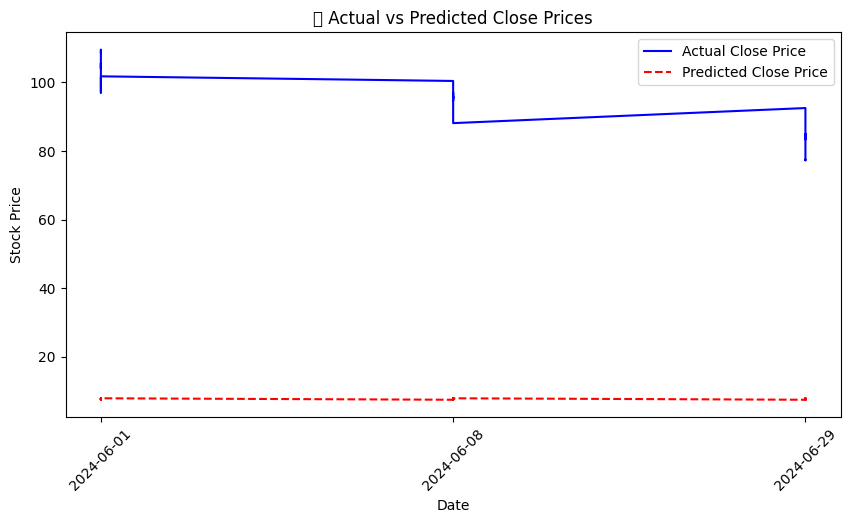

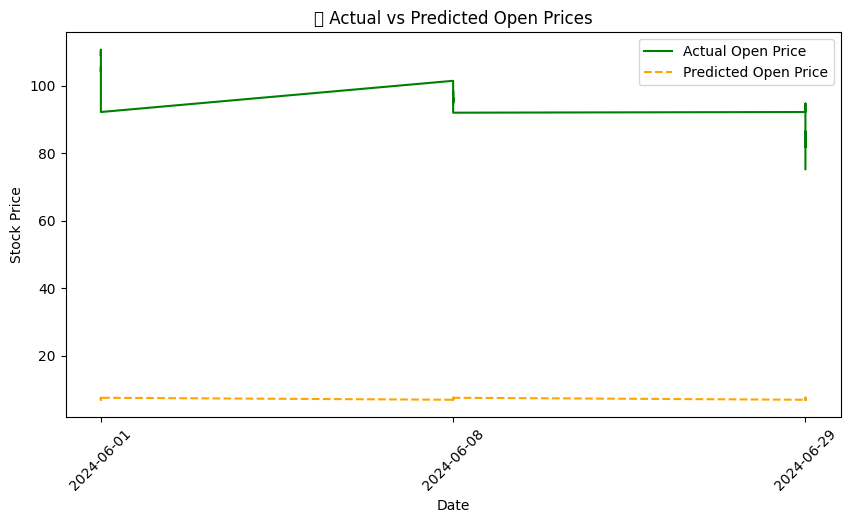

In [ ]:
import matplotlib.pyplot as plt

# ✅ Plot Close Prices
plt.figure(figsize=(10,5))
plt.plot(comparison_df["Date"], comparison_df["Actual Close Price"], label="Actual Close Price", color="blue")
plt.plot(comparison_df["Date"], comparison_df["Predicted Close Price"], label="Predicted Close Price", linestyle="dashed", color="red")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("📈 Actual vs Predicted Close Prices")
plt.xticks(rotation=45)
plt.show()

# ✅ Plot Open Prices
plt.figure(figsize=(10,5))
plt.plot(comparison_df["Date"], comparison_df["Actual Open Price"], label="Actual Open Price", color="green")
plt.plot(comparison_df["Date"], comparison_df["Predicted Open Price"], label="Predicted Open Price", linestyle="dashed", color="orange")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("📈 Actual vs Predicted Open Prices")
plt.xticks(rotation=45)
plt.show()


In [ ]:
print("\n✅ News Data Columns Before Merging:", news_data.columns)
print(news_data.head())  # Show first few rows


In [ ]:
print(news_data[['news_summary', 'sentiment']].head(10))  # Verify Sentiment Values


                                        news_summary  sentiment
0  UNESCO Goodwill Ambassador and Founder of the ...          1
1  India's most innovative deals have finally bee...          1
2  Adani has seen his ventures prosper at a brisk...          1
3  Despite vehement political opposition, the Utt...          1
4  Scientists have shown that a bacterial cell ca...          1
5  Promos of “Ishqiya” have caught on in a big wa...         -1
6  At 20, Saina Nehwal finds herself at the foref...          1
7  The paraphernalia of power and status that go ...         -1
8  Fatima Meer, who has died aged 81 after a stro...          1
9  Children who scavenge trash for a living repor...          1


In [ ]:
from transformers import pipeline

# Load model
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=-1)

# Test sentiment on sample news
test_sentiment = sentiment_pipeline("Stock market is crashing!")
print(test_sentiment)  # Should return POSITIVE or NEGATIVE


Device set to use cpu


[{'label': 'NEGATIVE', 'score': 0.9996507167816162}]


In [ ]:
import pandas as pd  

# ✅ Load news data
news_data = pd.read_csv('news_data.csv')

# ✅ Ensure columns exist
print("\n✅ News Data Columns:", news_data.columns)



✅ News Data Columns: Index(['date', 'title', 'news_summary'], dtype='object')


In [ ]:
print(stock_data[['date']].head(10))  # Show first 10 parsed dates


In [ ]:
if 'sentiment' in news_data.columns:
    news_data['sentiment'] = news_data['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': -1}).fillna(0)
    print("\n✅ Sentiment Mapping Successful!")
else:
    print("\n❌ Error: 'sentiment' column is missing in news_data!")



❌ Error: 'sentiment' column is missing in news_data!
